In [9]:
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

USERNAME_OVERRIDES = {'mattmallen': 'matt'}



def load(filepath):
    df = pd.json_normalize(pd.read_json(filepath)["trades"])
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df['buyer'] = df['buyer'].apply(lambda x: USERNAME_OVERRIDES.get(x, x))
    df['seller'] = df['seller'].map(lambda x: USERNAME_OVERRIDES.get(x, x))
    df = df.sort_values("timestamp")
    return df



In [10]:
round_1 = load("w3r1.json")
# round_2 = load("w3r2.json")

# round_2 = load("round2.json")
# round_3 = load("round3.json")

In [11]:
round_1 = round_1[round_1['product'] != 'PROD']

In [12]:
round_1_settlement = {"150 CALL": 0.0, "FUTURE": 137.0, "130 PUT": 0.0 }
round_2_settlement = {"150 CALL": 0.0, "FUTURE": 138.0, "130 PUT": 0.0 }

In [13]:
def show_trading_per_user(df, user):
    products = df["product"].unique()
    products = sorted(products)
    fig = make_subplots(
        rows=len(products),
        cols=1,
        shared_xaxes=True,
        subplot_titles=products,
        specs=[[{"secondary_y": True}] for _ in products],
    )

    for i, product in enumerate(products):
        product_df = df[df["product"] == product]

        # Calculate user's position in the product
        product_df["position"] = 0
        product_df.loc[product_df["buyer"] == user, "position"] = product_df["volume"]
        product_df.loc[product_df["seller"] == user, "position"] = -product_df["volume"]
        product_df["position"] = product_df["position"].cumsum()

        fig.add_trace(
            go.Scatter(
                x=product_df["timestamp"],
                y=product_df["position"],
                mode="lines",
                name=f"{user} Position in {product}",
                line=dict(color="grey", width=2),
                line_shape="hv",
            ),
            row=i + 1,
            col=1,
            secondary_y=True,
        )
        fig.add_trace(
            go.Scatter(
                x=product_df["timestamp"],
                y=product_df["price"],
                mode="lines",
                name=f"{product} Last Traded Price",
                line=dict(color="blue"),
                marker=dict(symbol="circle", size=6),
                line_shape="hv",
            ),
            row=i + 1,
            col=1,
        )

        user_buys = product_df[product_df["buyer"] == user]
        user_sells = product_df[product_df["seller"] == user]

        # Plot user buy trades
        fig.add_trace(
            go.Scatter(
                x=user_buys["timestamp"],
                y=user_buys["price"],
                mode="markers",
                name=f"{user} Buy {product}",
                marker=dict(
                    color="green",
                    symbol="triangle-up",
                    size=(1 + np.log10(user_buys["volume"])) * 15,
                ),
            ),
            row=i + 1,
            col=1,
        )

        # Plot user sell trades
        fig.add_trace(
            go.Scatter(
                x=user_sells["timestamp"],
                y=user_sells["price"],
                mode="markers",
                name=f"{user} Sell {product}",
                marker=dict(
                    color="orange",
                    symbol="triangle-down",
                    size=(1 + np.log10(user_sells["volume"])) * 15,
                ),
            ),
            row=i + 1,
            col=1,
        )

    fig.update_layout(
        title=f"Trading Activity for User: {user}",
        xaxis_title="Timestamp",
        yaxis_title="Price / Position",
        height=400 * len(products),
        showlegend=False,
        # margin=dict(l=40, r=40, t=40, b=40)
    )

    fig.show()

In [14]:
def get_per_product_stats(df, product_settlements):
    products = df["product"].unique()
    products = sorted(products)
    players = list(set(df["buyer"]) | set(df["seller"]))
    all_player_stats = []
    for product in products:
        settlement = product_settlements[product]
        df_product = df[df["product"] == product]
        for player in players:
            player_buys = df_product[df_product["buyer"] == player]
            player_sells = df_product[df_product["seller"] == player]

            buy_volume = 0 if len(player_buys) == 0 else player_buys["volume"].sum()
            sell_volume = 0 if len(player_sells) == 0 else player_sells["volume"].sum()
            if len(player_buys) > 0:
                buy_pnl = (
                    (settlement - player_buys["price"]) * player_buys["volume"]
                ).sum()
                average_buy = (
                    player_buys["price"] * player_buys["volume"]
                ).sum() / buy_volume
                average_buy = round(average_buy, 2)
            else:
                buy_pnl = 0
                average_buy = None

            if len(player_sells) > 0:
                sell_pnl = (
                    (player_sells["price"] - settlement) * player_sells["volume"]
                ).sum()
                average_sell = (
                    player_sells["price"] * player_sells["volume"]
                ).sum() / sell_volume
                average_sell = round(average_sell, 2)
            else:
                sell_pnl = 0
                average_sell = None
            all_player_stats.append(
                {
                    "Total PnL": buy_pnl + sell_pnl,
                    "Buy Volume": buy_volume,
                    "Sell Volume": sell_volume,
                    "Total Volume": buy_volume + sell_volume,
                    "Two-Way Volume": min(buy_volume, sell_volume),
                    "Buy PnL": buy_pnl,
                    "Sell PnL": sell_pnl,
                    "Average Buy Price": average_buy,
                    "Average Sell Price": average_sell,
                    "User": player,
                    "Product": product,
                }
            )

    return (
        pd.DataFrame(all_player_stats)
        .sort_values(["Product", "Total PnL"], ascending=[True, False])
        .set_index(["Product", "User"])
    )


def get_aggregate_stats(df, product_settlements):
    per_product_stats = get_per_product_stats(df, product_settlements)
    df_agg = per_product_stats.groupby("User")[
        [
            "Total PnL",
            "Buy Volume",
            "Sell Volume",
            "Total Volume",
            "Buy PnL",
            "Sell PnL",
        ]
    ].agg(
        {
            "Total PnL": "sum",
            "Buy Volume": "sum",
            "Sell Volume": "sum",
            "Total Volume": "sum",
            "Buy PnL": "sum",
            "Sell PnL": "sum",
        }
    )
    df_agg["Two-Way Volume"] = df_agg.apply(
        lambda x: round(min(x["Buy Volume"], x["Sell Volume"])), axis=1
    )
    df_agg["PnL Ranking"] = df_agg["Total PnL"].rank(method="min") - 1
    positive_pnl = df_agg[df_agg["Total PnL"] > 0]
    positive_pnl["Profitbale Two-Way Trading Ranking"] = positive_pnl["Two-Way Volume"].rank(method="min") - 1
    df_agg["Profitbale Two-Way Trading Ranking"] = positive_pnl["Profitbale Two-Way Trading Ranking"]
    df_agg["Profitbale Two-Way Trading Ranking"].fillna(0.0, inplace=True)
    df_agg['Total Points'] = df_agg["Profitbale Two-Way Trading Ranking"] + df_agg["PnL Ranking"]
    return df_agg.sort_values('Total Points', ascending=False)

In [15]:
round_1_stats = get_aggregate_stats(round_1, round_1_settlement)
# round_1_stats.reset_index().to_csv('./round_1_stats.csv')
round_1_stats

,Total PnL,Buy Volume,Sell Volume,Total Volume,Buy PnL,Sell PnL,Two-Way Volume,PnL Ranking,Profitbale Two-Way Trading Ranking,Total Points
User,,,,,,,,,,
test,452.25,303,319,622,1421.25,-969.00,303,2.0,0.0,2.0
FutureTrader,-153.50,359,338,697,1396.50,-1550.00,338,1.0,0.0,1.0
Deniz,-298.75,160,165,325,217.50,-516.25,160,0.0,0.0,0.0


In [29]:
round_2_stats = get_aggregate_stats(round_2, round_2_settlement)
# round_1_stats.reset_index().to_csv('./round_1_stats.csv')
round_2_stats

,Total PnL,Buy Volume,Sell Volume,Total Volume,Buy PnL,Sell PnL,Two-Way Volume,PnL Ranking,Profitbale Two-Way Trading Ranking,Total Points
User,,,,,,,,,,
atandon,681.00,451,621,1072,734.25,-53.25,451,23.0,14.0,37.0
Junrong,406.50,630,380,1010,1253.50,-847.00,380,20.0,13.0,33.0
sam1,506.50,179,423,602,-109.50,616.00,179,22.0,10.0,32.0
efe,258.50,355,371,726,873.00,-614.50,355,19.0,12.0,31.0
jakub,485.25,206,142,348,-98.75,584.00,142,21.0,9.0,30.0
masha,205.00,67,67,134,353.00,-148.00,67,16.0,5.0,21.0
Mattia,204.00,87,87,174,276.00,-72.00,87,15.0,6.0,21.0
orlando,256.75,49,65,114,29.50,227.25,49,18.0,3.0,21.0
mo,224.00,69,51,120,205.50,18.50,51,17.0,4.0,21.0


In [17]:
show_trading_per_user(round_1, "test")

In [90]:
round_2_stats = get_aggregate_stats(round_2, round_2_settlement)
round_2_stats.reset_index().to_csv('./round_2_stats.csv')
round_2_stats

,Total PnL,Buy Volume,Sell Volume,Total Volume,Buy PnL,Sell PnL,Two-Way Volume,PnL Ranking,Profitbale Two-Way Trading Ranking,Total Points
User,,,,,,,,,,
cmi,392.00,164,89,253,1128.25,-736.25,89,22.0,13.0,35.0
Kai,1099.50,133,49,182,1369.00,-269.50,49,23.0,12.0,35.0
Junrong,86.00,30,34,64,199.75,-113.75,30,19.0,10.0,29.0
Mattia,116.25,31,24,55,332.50,-216.25,24,20.0,9.0,29.0
orlando,47.50,31,30,61,336.75,-289.25,30,18.0,10.0,28.0
arun,192.50,36,19,55,284.50,-92.00,19,21.0,7.0,28.0
mohamed,46.50,19,21,40,285.25,-238.75,19,17.0,7.0,24.0
jakub,22.50,11,10,21,156.25,-133.75,10,16.0,3.0,19.0
lpantea,17.00,13,10,23,57.75,-40.75,10,15.0,3.0,18.0


In [91]:
round_3_stats = get_aggregate_stats(round_3, round_3_settlement)
round_3_stats.reset_index().to_csv('./round_3_stats.csv')
round_3_stats

,Total PnL,Buy Volume,Sell Volume,Total Volume,Buy PnL,Sell PnL,Two-Way Volume,PnL Ranking,Profitbale Two-Way Trading Ranking,Total Points
User,,,,,,,,,,
cmi,854.75,379,520,899,-902.50,1757.25,379,23.0,16.0,39.0
ben,636.50,198,166,364,-79.50,716.00,166,22.0,15.0,37.0
mohamed,574.25,53,96,149,-95.75,670.00,53,21.0,13.0,34.0
efe,91.50,61,87,148,-197.50,289.00,61,17.0,14.0,31.0
orlando,77.75,39,48,87,-151.25,229.00,39,15.0,11.0,26.0
henryli,128.50,22,22,44,-36.50,165.00,22,18.0,8.0,26.0
arun,178.50,15,259,274,-100.25,278.75,15,20.0,6.0,26.0
oalkhati,35.75,39,54,93,-189.00,224.75,39,12.0,11.0,23.0
masha,80.25,15,15,30,-11.00,91.25,15,16.0,6.0,22.0


In [92]:
total_points = round_1_stats['Total Points'] + round_2_stats['Total Points'] + round_3_stats['Total Points']

In [93]:
total_points.sort_values(ascending=False)

User
cmi         104.0
arun         82.0
mohamed      75.0
henryli      63.0
masha        63.0
Junrong      61.0
lpantea      60.0
Kai          59.0
Ani          59.0
orlando      55.0
jakub        46.0
Victoria     43.0
ben          43.0
oalkhati     40.0
matt         40.0
Mattia       38.0
hubert       36.0
efe          34.0
boyko        34.0
Hongshu      26.0
Deniz        25.0
jruiz        17.0
Una          15.0
sam          14.0
azinho        NaN
Name: Total Points, dtype: float64

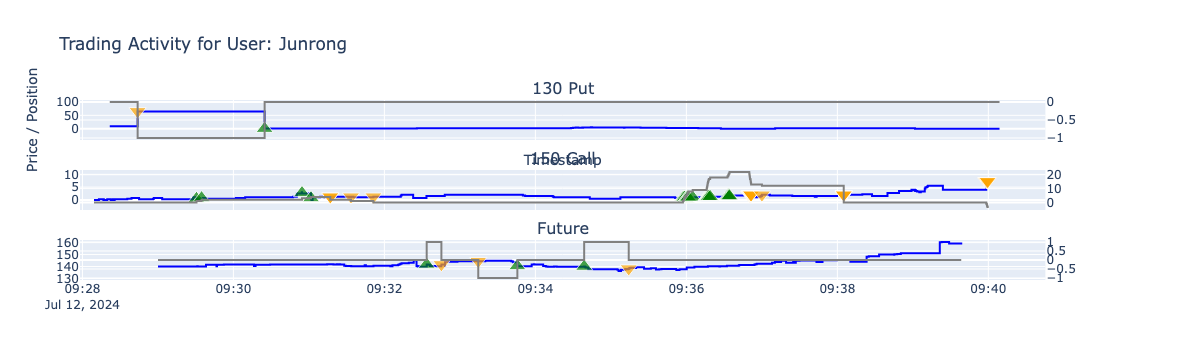

In [102]:
show_trading_per_user(round_2, "cmi")